# Import Requirements

In [2]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn import preprocessing
from scipy import stats
import csv

Using TensorFlow backend.
/Users/nn2tf/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/nn2tf/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/nn2tf/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/nn2tf/anaconda3/lib/python3.7/site-packages/tenso

I tried to get rid of a warning related to keras 

In [3]:
import os
import sys
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Keras outputs warnings using `print` to stderr so let's direct that to devnull temporarily
stderr = sys.stderr
sys.stderr = open(os.devnull, 'w')

import keras

# we're done
sys.stderr = stderr

from keras.backend.tensorflow_backend import tf

import absl.logging
logging.root.removeHandler(absl.logging._absl_handler)
absl.logging._warn_preinit_stderr = False

logger = tf.get_logger()
logger.setLevel(logging.FATAL)

graph = tf.get_default_graph()

# Data Preprocessing
For this project, I use the experimental data collected from an experimental lake called Peter lake located at the University of Notre Dame Environmental Research Center on the Wisconsin-Upper Peninsula of Michigan border. These are small lakes on a private research station, where the Pace Lab has been conducting whole-lake experiments for over 30 years. The water quality data were collected in 5-minutes frequency, including Chlorophyll-a, PH, and DO. Weather data collected from the nearest weather station, including wind direction, wind speed, air temperature, and PAR data, are also available in 5 minutes frequency. The last piece of required data is the water temperature profile available in 5 minutes frequency. I used this data to engineer a new attribute called Zmix. The Zmix is the depth that water is considered thoroughly mixed. I calculated the temperature at Zmix, which could potentially be used to predict algae concentration. This project predicts Chrorophyl-a concentration as a proxy of algae bloom. 
As the next step in preprocessing data, we integrated all three datasets, treated the missing values and smoothed them daily. We also added the nutrient loading rate and calculated the cumulative rate. 
As the last step, we normalized all variables, especially the loading rates were normalized using lake color.

# Loading cleaned Dataset

In [319]:
dataset = read_csv('ExperimentalLakes_Data_withColorNormalizedCumulativePloading.csv', header=0, index_col=3, parse_dates=True, squeeze=False)

In [55]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2160 entries, 2008-05-15 to 2015-09-03
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   lake                2160 non-null   object 
 1   year                2160 non-null   int64  
 2   doy                 2160 non-null   int64  
 3   temp_sonde          2160 non-null   float64
 4   ph                  2156 non-null   float64
 5   do_sat              2160 non-null   float64
 6   do_conc             2160 non-null   float64
 7   bga_hylb            1288 non-null   float64
 8   chl                 2160 non-null   float64
 9   zmix_daily          2092 non-null   float64
 10  temp_zmix_daily     2092 non-null   float64
 11  zmix_hf             1883 non-null   float64
 12  temp_zmix_hf        1883 non-null   float64
 13  par                 2154 non-null   float64
 14  temp_air            2154 non-null   float64
 15  wind_spd            2136 non-null   f

In [213]:
#Data Preprocessing (Filtering the Peter Lake data, keep only Chla column, droping missing Chl values, normalizing Chla data)

def data_prep_uni(dataset, lake):
    ex = dataset[dataset.lake==lake]
    ex = ex.dropna(subset=["chl"])
    #min_max_scaler = preprocessing.MinMaxScaler()
    #ex = min_max_scaler.fit_transform(ex.reshape(-1, 1))*100
    return ex

In [214]:
#filtering out the lake peter data
df_R = data_prep_uni (dataset,"R")

In [215]:
print(df_R.head())

           lake  year  doy  temp_sonde        ph      do_sat    do_conc  \
date                                                                      
2008-05-15    R  2008  136   13.970398  7.535841  114.868515  11.128927   
2008-05-16    R  2008  137   15.116002  7.483378  114.294443  10.799854   
2008-05-17    R  2008  138   14.782927  7.441546  111.460435  10.608380   
2008-05-18    R  2008  139   13.788608  7.483690  108.981426  10.601019   
2008-05-19    R  2008  140   13.556983  7.580487  110.187882  10.773516   

            bga_hylb       chl  zmix_daily  ...    wind_dir  p_loading  \
date                                        ...                          
2008-05-15       NaN   8.08505         1.5  ...  211.704514        0.0   
2008-05-16       NaN  14.42403         1.5  ...  254.904861        0.0   
2008-05-17       NaN  11.80493         2.0  ...  297.471528        0.0   
2008-05-18       NaN  11.74800         2.0  ...  265.675000        0.0   
2008-05-19       NaN  11.99472

# Exploratory data Analysis
Here you can see algae abundance fluctuations between 2008 to 2019. It should be noted that algal bloom usually happend in warm seasons, so no data is collected in seasons that algal bloom is elast likly to happen. Moreover, sensor data is not available for lake peter in 2012, 2016 and 2017. Data was collected through summer season for most of years for day of year 133 to 248.

In [216]:
years= sorted(list(set(df_R['year'])))

<AxesSubplot:xlabel='date'>

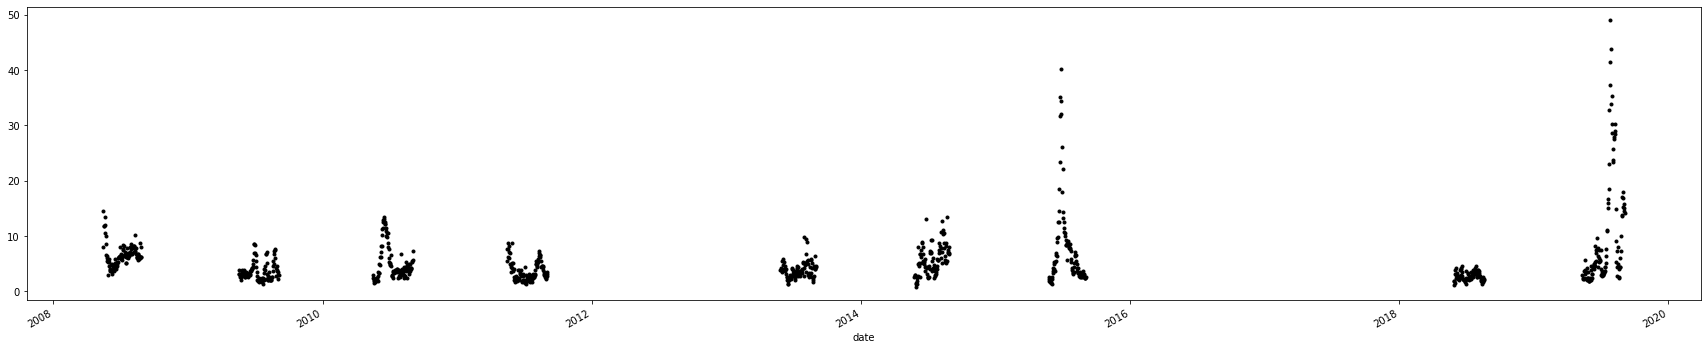

In [217]:
plt.figure(figsize=(30,6))
df_R['chl'].plot(style='k.')

In [218]:
df_chl= df_R['chl']

In [219]:
years

[2008, 2009, 2010, 2011, 2013, 2014, 2015, 2018, 2019]

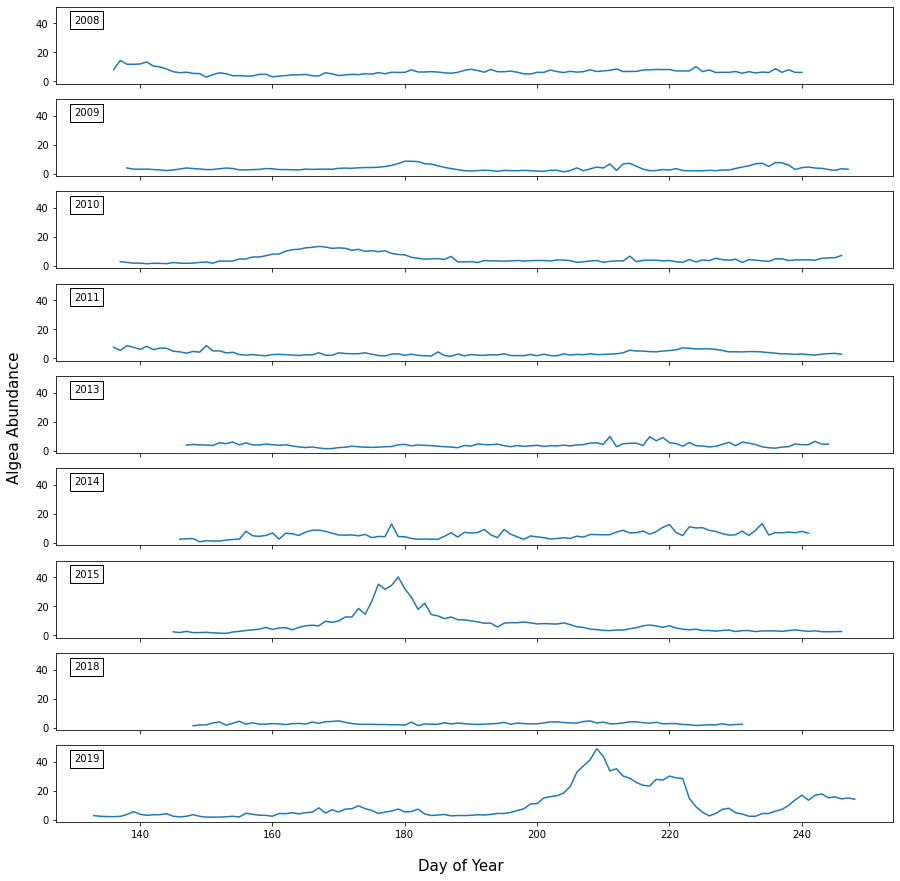

In [220]:
fig, axs = plt.subplots(9, sharex=True, sharey=True, figsize=(15,15))
for i in range(len(years)):
    sub_df= df_R[df_R['year']==years[i]]
    axs[i].plot(sub_df['doy'], sub_df['chl'])
    axs[i].text(130, 40, years[i], color='black', 
        bbox=dict(facecolor='none', edgecolor='black'))
fig.text(0.5, 0.08, 'Day of Year', ha='center', fontsize=15)
fig.text(0.08, 0.5, 'Algea Abundance', va='center', rotation='vertical', fontsize=15 ) 
plt.show()

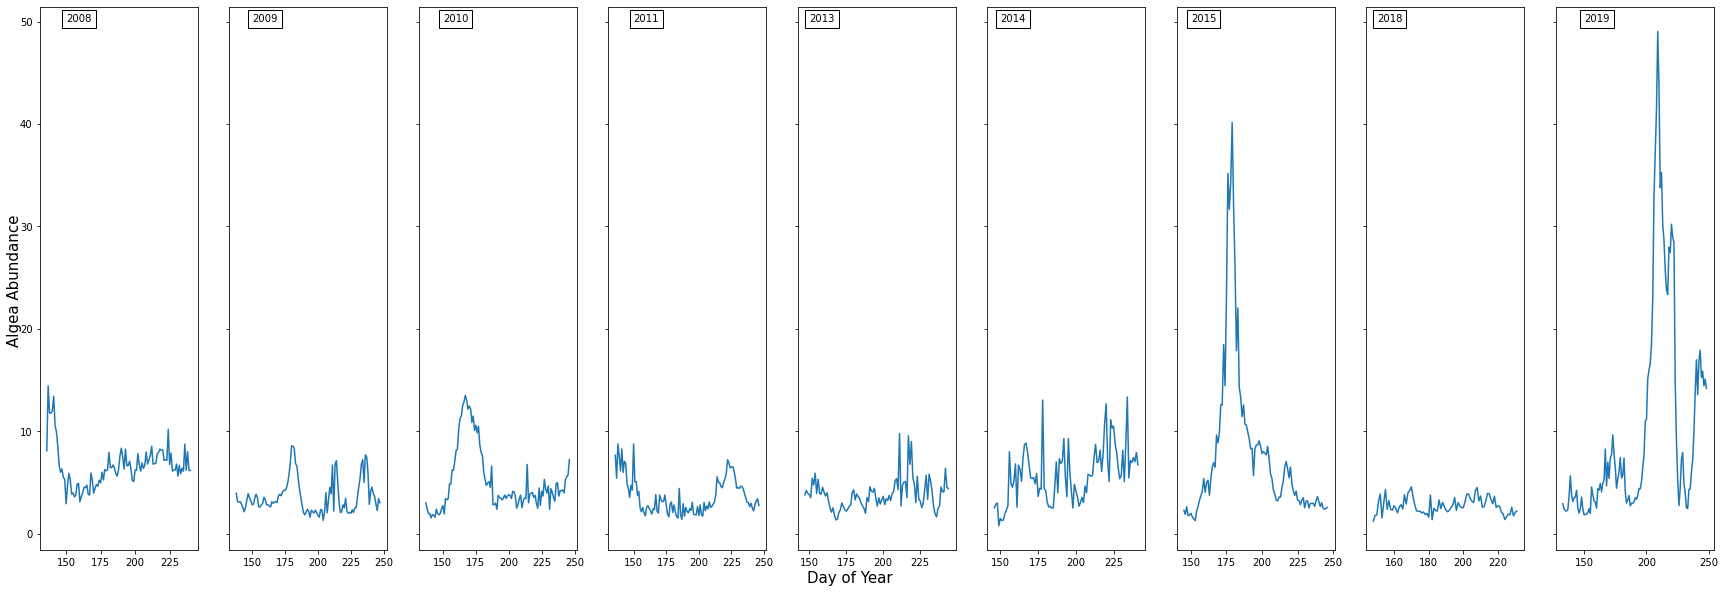

In [221]:
fig = plt.figure(figsize=(30,10))
gs = fig.add_gridspec(1,9, hspace=0)
axs = gs.subplots(sharex=False, sharey=True)
fig.suptitle('')
for i in range(len(years)):
    sub_df= df_R[df_R['year']==years[i]]
    axs[i].plot(sub_df['doy'], sub_df['chl'])
    axs[i].text(150, 50, years[i], color='black', 
        bbox=dict(facecolor='none', edgecolor='black'))
fig.text(0.5, 0.08, 'Day of Year', ha='center', fontsize=15)
fig.text(0.11, 0.5, 'Algea Abundance', va='center', rotation='vertical', fontsize=15 ) 
plt.show()


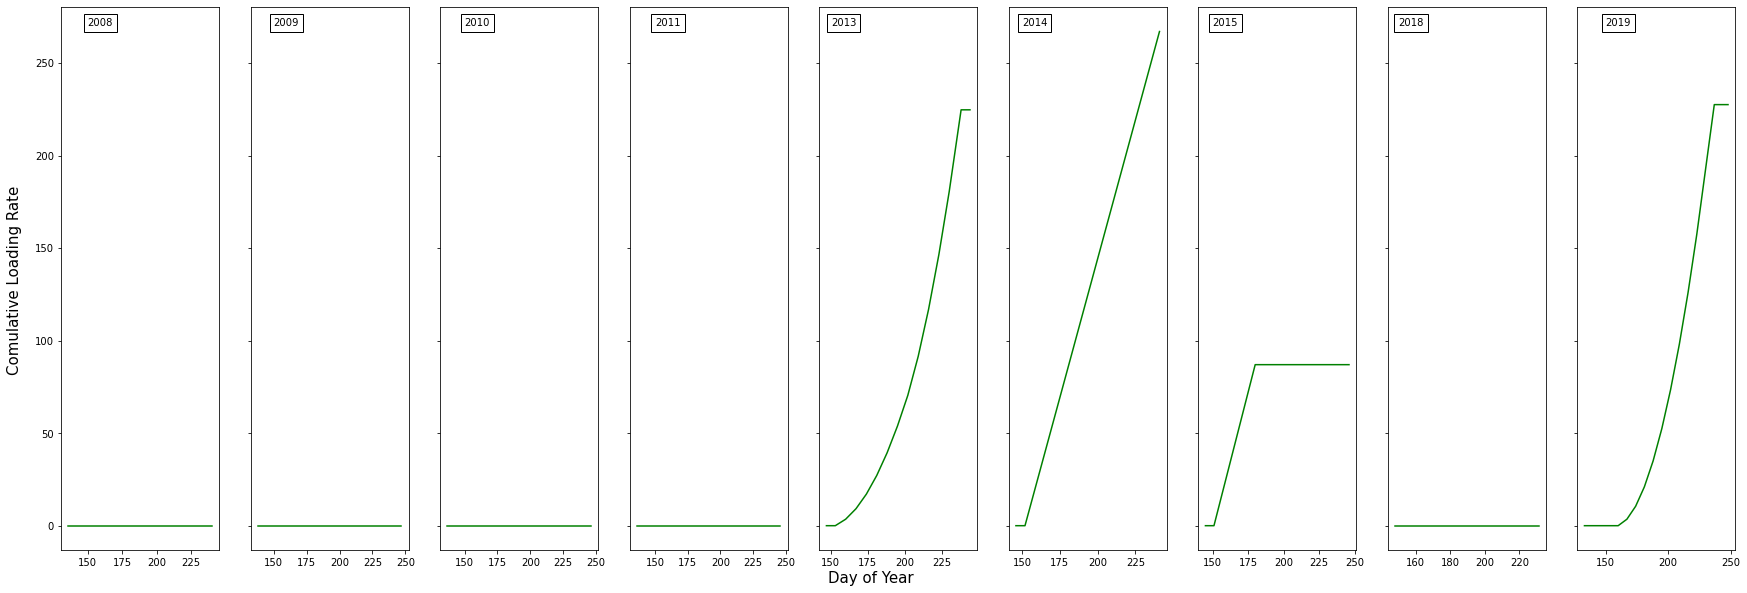

In [222]:
fig = plt.figure(figsize=(30,10))
gs = fig.add_gridspec(1,9, hspace=0)
axs = gs.subplots(sharex=False, sharey=True)
fig.suptitle('')
for i in range(len(years)):
    sub_df= df_R[df_R['year']==years[i]]
    axs[i].plot(sub_df['doy'], sub_df['p_cumulative'],'g-' )
    axs[i].text(150, 270, years[i], color='black', 
        bbox=dict(facecolor='none', edgecolor='black'))
fig.text(0.5, 0.08, 'Day of Year', ha='center', fontsize=15)
fig.text(0.10, 0.5, 'Comulative Loading Rate', va='center', rotation='vertical', fontsize=15 ) 
plt.show()

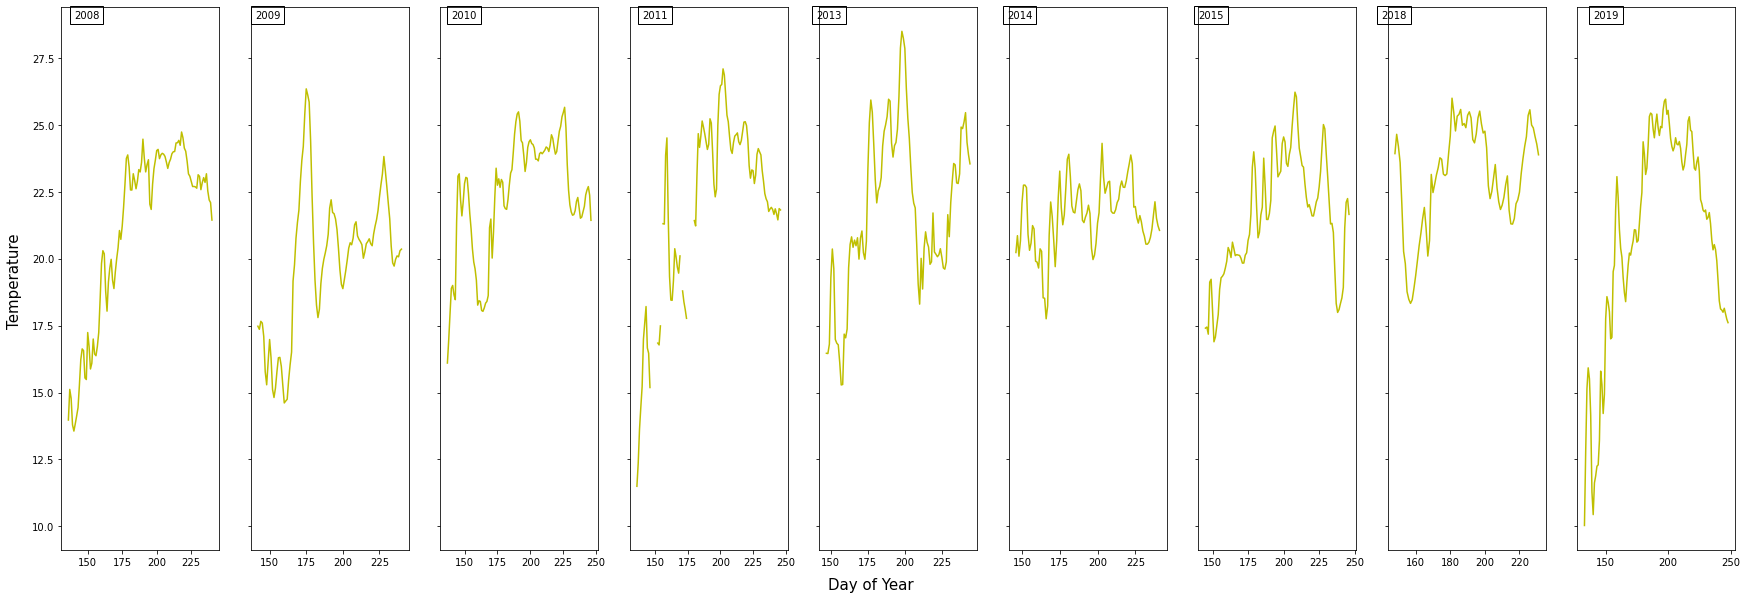

In [223]:
fig = plt.figure(figsize=(30,10))
gs = fig.add_gridspec(1,9, hspace=0)
axs = gs.subplots(sharex=False, sharey=True)
fig.suptitle('')

for i in range(len(years)):
    sub_df= df_R[df_R['year']==years[i]]
    axs[i].plot(sub_df['doy'], sub_df['temp_zmix_daily'],'y-' )
    axs[i].text(140, 29, years[i], color='black', 
        bbox=dict(facecolor='none', edgecolor='black'))
    
fig.text(0.5, 0.07, 'Day of Year', ha='center', fontsize=15)
fig.text(0.10, 0.5, 'Temperature', va='center', rotation='vertical', fontsize=15 ) 
plt.show()

# 

# Univariate Models

The univariate models use only chlrophyll-a past data to forecast future ones.

In [230]:
ex_R= np.array(df_R['chl'])

split a univariate dataset into train/test sets. Train set includes all year before 2019 and models are tested against 2019 data.

In [231]:

def split_dataset(data):
	# split into standard weeks
	train, test = data[1:816], data[816:]
	# restructure into windows of weekly data
	#train = array(split(train, len(train)/7))
	#test = array(split(test, len(test)/7))
	return train, test

In [229]:
# split into train and test
train, test = split_dataset(ex_R)
train= train.reshape(train.shape[0], 1)
test= test.reshape(test.shape[0], 1)

In [11]:
#np.savetxt('test_observations.csv', test, fmt='%1.6f', delimiter=',')

For sequential model, we need to convert history into inputs and outputs. In this case we converted data to sliding windows of seven days before (input window) and seven-days after (output window)

In [240]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], 1))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# Naive Model

In order to compare the performnace of forecasting, we need a baseline or naive model. We developed a persistence model as a baseline. This ppersistence model assume that todays algea concentration will remain persistant for the next one to seven days.

In [241]:
# naive forecast strategies for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

In [242]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts_Naive(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
        # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [243]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [244]:
#evaluate a single model
def evaluate_model_naive(daily_persistence, train, test):
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)-7):
        # predict the week
        yhat_sequence = daily_persistence(history)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    predictions = array(predictions)
    test_x, test_y= to_supervised(test, 7, 1)
    
    score, scores= evaluate_forecasts_Naive(test_x, predictions)
    # evaluate predictions days for each week
    return score, scores, predictions

In [245]:
# daily persistence model
def daily_persistence(history):
    # get the data for the prior week
    last_week = history[-1]
    # get the total active power for the last day
    value = last_week[-1]
    # prepare 7 day forecast
    forecast = [value for _ in range(7)]
    return forecast

In [246]:
# evaluate and get scores
score_Naive, scores_Naive, prediction_Naive = evaluate_model_naive (daily_persistence, train, test)

In [247]:
# summarize scores
summarize_scores('Daily Persistence', score_Naive, scores_Naive)

Daily Persistence: [7.314] 2.8, 4.5, 6.1, 7.4, 8.4, 9.2, 9.9


In [248]:
np.savetxt('prediction_Naive.csv', prediction_Naive, fmt='%1.6f', delimiter=',')

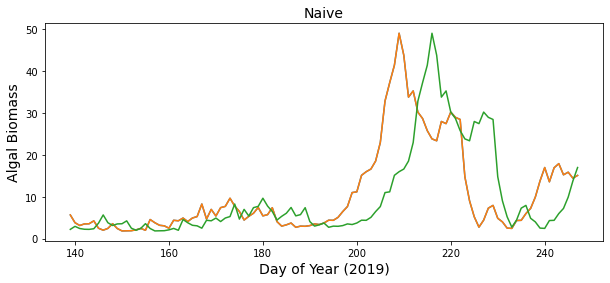

In [260]:
plt.figure(figsize=(10,4))
plt.plot(doy,actual, label='Actual')
Naive = prediction_Naive [:,6]
plt.plot(doy,actual, doy, Naive)
plt.title("Naive", fontsize=14)
plt.xlabel('Day of Year (2019)',fontsize=14)
plt.ylabel('Algal Biomass',fontsize=14)
plt.show()

slope, intercept, r_value, p_value, std_err = stats.linregress(test_x[7:, 6, 0], prediction_Naive[:, 6])
print(slope, intercept, r_value, p_value, std_err)

## CNN multi-step forecasting

In [249]:
# train the model
def build_model_CNN(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 50, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(Conv1D(32, 2, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(MaxPooling1D())
	model.add(Flatten())
	model.add(Dense(50, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [250]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	#data = data.reshape((data.shape[0]*data.shape[1], 1))
	# retrieve last observations for input data (It is 7 last observations of train data)
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [251]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[7:, i], predicted[7:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [252]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [253]:
# evaluate a single model
def evaluate_model_CNN(train, test, n_input):
	# fit model
	model = build_model_CNN(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)-7):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	test_x, test_y= to_supervised(test, 7, 1)
	score, scores = evaluate_forecasts(test_x[:, :, 0], predictions)
	return score, scores, predictions

In [254]:
# evaluate model and get scores
n_input = 7
score_CNN, scores_CNN, prediction_CNN= evaluate_model_CNN(train, test, n_input)

In [255]:
# summarize scores
summarize_scores('cnn', score_CNN, scores_CNN)

cnn: [6.900] 3.4, 4.8, 6.1, 7.1, 8.2, 8.8, 9.4


slope, intercept, r_value, p_value, std_err = stats.linregress(test_x[7:, 6, 0], prediction_CNN[:, 6])
print(slope, intercept, r_value, p_value, std_err)

In [256]:
prediction_CNN.shape

(109, 7)

In [257]:
np.savetxt('prediction_CNN.csv', prediction_CNN, fmt='%1.6f', delimiter=',')

In [258]:
doy = range(139,248)
actual = test[6:-1]

findfont: Font family ['Ubuntu Mono'] not found. Falling back to DejaVu Sans.


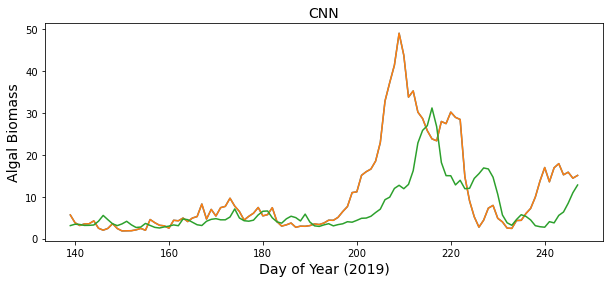

In [259]:
plt.figure(figsize=(10,4))
plt.plot(doy,actual, label='Actual')
CNN = prediction_CNN [:,6]
plt.plot(doy,actual, doy, CNN)
plt.title("CNN", fontsize=14)
plt.xlabel('Day of Year (2019)',fontsize=14)
plt.ylabel('Algal Biomass',fontsize=14)
plt.show()

# LSTM Univariate

In [261]:
from keras.layers import LSTM

In [262]:
# train the model
def build_model_LSTM(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 50, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [263]:
# evaluate a single model
def evaluate_model_LSTM(train, test, n_input):
    # fit model
    model = build_model_LSTM(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)-7):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    test_x, test_y= to_supervised(test, 7, 1)
    score, scores = evaluate_forecasts_Naive(test_x[:, :], predictions)
    return score, scores, predictions

In [264]:
# evaluate model and get scores
n_input = 7
score_LSTM, scores_LSTM, predictions_LSTM = evaluate_model_LSTM(train, test, n_input)
# summarize scores
summarize_scores('lstm', score_LSTM, scores_LSTM)

lstm: [6.018] 3.9, 4.6, 5.4, 5.9, 6.5, 7.0, 7.8


In [265]:
np.savetxt('predictions_LSTM.csv', predictions_LSTM,fmt='%1.6f', delimiter=',')

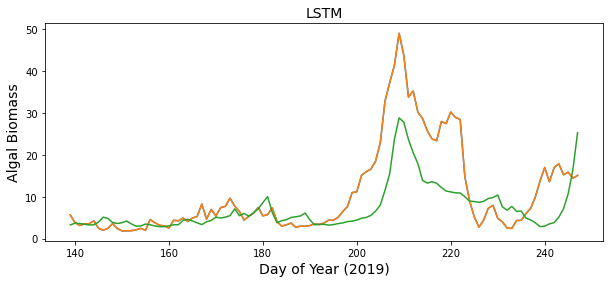

In [266]:
plt.figure(figsize=(10,4))
plt.plot(doy,actual, label='Actual')
LSTM = predictions_LSTM [:,6]
plt.plot(doy,actual, doy, LSTM)
plt.title("LSTM", fontsize=14)
plt.xlabel('Day of Year (2019)',fontsize=14)
plt.ylabel('Algal Biomass',fontsize=14)
plt.show()

## Encoder- Decoder LSTM with univariate input

In [267]:
from keras.layers import LSTM

In [268]:
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [269]:
# train the model
def build_model_LSTM_EnDe(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 50, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [270]:
# evaluate a single model
def evaluate_model_LSTM_EnDe(train, test, n_input):
    # fit model
    model = build_model_LSTM_EnDe(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)-7):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    test_x, test_y= to_supervised(test, 7, 1)
    score, scores = evaluate_forecasts_Naive(test_x[:, :], predictions)
    return score, scores, predictions

In [271]:
# evaluate model and get scores
n_input = 7
score_LSTM_EnDe, scores_LSTM_EnDe, predictions_LSTM_EnDe = evaluate_model_LSTM_EnDe(train, test, n_input)
# summarize scores
summarize_scores('lstm_EnDe', score_LSTM_EnDe, scores_LSTM_EnDe)

lstm_EnDe: [6.958] 4.1, 5.6, 6.8, 7.5, 7.8, 7.9, 8.1


In [272]:
predictions_LSTM_EnDe= predictions_LSTM_EnDe.reshape(predictions_LSTM_EnDe.shape[0], predictions_LSTM_EnDe.shape[1])

In [273]:
np.savetxt('predictions_LSTM_EnDe.csv', predictions_LSTM_EnDe, fmt='%1.6f', delimiter=',')

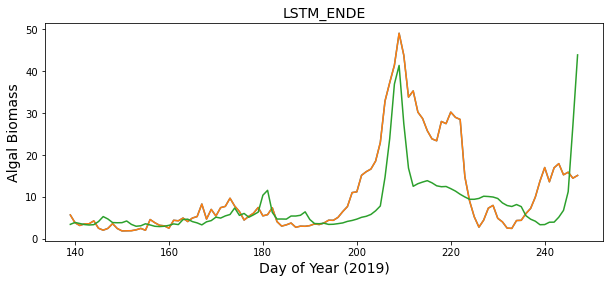

In [274]:
plt.figure(figsize=(10,4))
plt.plot(doy,actual, label='Actual')
LSTM_ENDE = predictions_LSTM_EnDe [:,6]
plt.plot(doy,actual, doy, LSTM_ENDE)
plt.title("LSTM_ENDE", fontsize=14)
plt.xlabel('Day of Year (2019)',fontsize=14)
plt.ylabel('Algal Biomass',fontsize=14)
plt.show()

# MLP Multi-step

In [275]:
# convert history into inputs and outputs
def to_supervised_MLP(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end]
			X.append(x_input)
			y.append(data[in_end:out_end])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [276]:
# train the model
def build_model_MLP(train, config):
    # prepare data
    n_input, n_nodes, n_epochs, n_batch = config
    train_x, train_y = to_supervised_MLP(train, n_input)
    # define parameters
    n_timesteps, n_outputs = train_x.shape[1], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

In [277]:
# make a forecast
def forecast_MLP(model, history, n_input):
	# flatten data
	data = array(history)
	#data = data.reshape((data.shape[0]*data.shape[1]))
	# retrieve last observations for input data
	input_x = data[-n_input:]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x)))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [278]:
# evaluate a single model
def evaluate_model_MLP(train, test, n_input):
    # fit model
    model = build_model_MLP(train, config)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)-7):
        # predict the week
        yhat_sequence = forecast_MLP(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    test_x, test_y= to_supervised(test, 7, 1)
    score, scores = evaluate_forecasts(test_x[:,:], predictions)
    return score, scores, predictions

In [279]:
# evaluate model and get scores
config = [7, 50, 50, 4]
score_MLP, scores_MLP, predictions_MLP = evaluate_model_MLP(train, test, n_input)
# summarize scores
summarize_scores('MLP', score_MLP, scores_MLP)

MLP: [7.085] 3.0, 4.6, 6.1, 7.5, 8.6, 9.2, 9.6


In [280]:
np.savetxt('predictions_MLP.csv', predictions_MLP, fmt='%1.6f', delimiter=',')

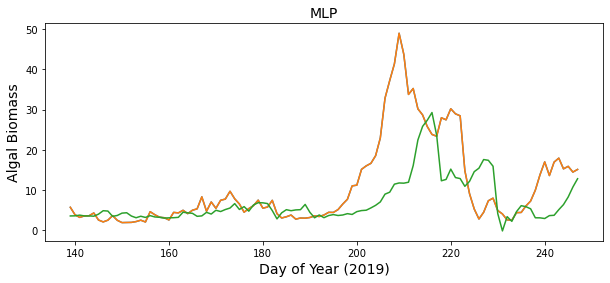

In [281]:
plt.figure(figsize=(10,4))
plt.plot(doy,actual, label='Actual')
MLP = predictions_MLP [:,6]
plt.plot(doy,actual, doy, MLP)
plt.title("MLP", fontsize=14)
plt.xlabel('Day of Year (2019)',fontsize=14)
plt.ylabel('Algal Biomass',fontsize=14)
plt.show()

## CNN-LSTM Encoder-Decoder With Univariate Input

In [282]:
# train the model
def build_model_hybrid(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 50, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(Conv1D(64, 2, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(64, 2, activation='relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [283]:
# evaluate a single model
def evaluate_model_hybrid(train, test, n_input):
	# fit model
	model = build_model_hybrid(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)-7):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	test_x, test_y= to_supervised(test, 7, 1)    
	score, scores = evaluate_forecasts(test_x[:, :, 0], predictions)
	return score, scores, predictions

In [284]:
# evaluate model and get scores
n_input = 7
score, scores_hybrid, predictions_hybrid = evaluate_model_hybrid(train, test, n_input)

In [285]:
# summarize scores
summarize_scores('cnn_hybrid', score, scores_hybrid)

cnn_hybrid: [6.587] 4.7, 5.5, 6.5, 7.0, 7.4, 7.7, 8.1


In [286]:
predictions_hybrid= predictions_hybrid.reshape(predictions_hybrid.shape[0], predictions_hybrid.shape[1])

In [287]:
np.savetxt('predictions_hybrid.csv', predictions_hybrid, fmt='%1.6f', delimiter=',')

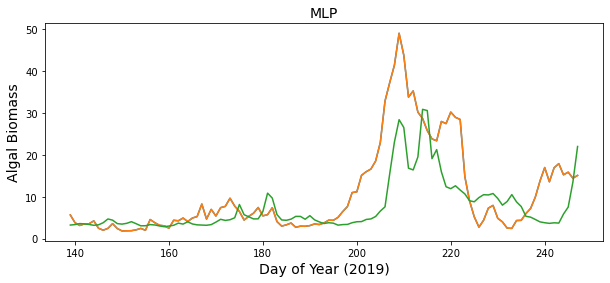

In [288]:
plt.figure(figsize=(10,4))
plt.plot(doy,actual, label='Actual')
cnn_hybrid = predictions_hybrid [:,6]
plt.plot(doy,actual, doy, cnn_hybrid)
plt.title("MLP", fontsize=14)
plt.xlabel('Day of Year (2019)',fontsize=14)
plt.ylabel('Algal Biomass',fontsize=14)
plt.show()

## ConvLSTM Encoder-Decoder With Univariate Input

In [289]:
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D

In [290]:
# train the model
def build_model_convLSTM(train, n_steps, n_length, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 20, 16
    n_features, n_outputs = train_x.shape[2], train_y.shape[1]
    # reshape into subsequences [samples, timesteps, rows, cols, channels]
    train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(64, (1,3), activation='relu', input_shape=(n_steps, 1, n_length,
    n_features)))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [291]:
# make a forecast
def forecast_convLSTM(model, history, n_steps, n_length, n_input):
    # flatten data
    data = array(history)
    #data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [samples, timesteps, rows, cols, channels]
    input_x = input_x.reshape((1, n_steps, 1, n_length, 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [292]:
# evaluate a single model
def evaluate_model_conLSTM(train, test, n_steps, n_length, n_input):
    # fit model
    model = build_model_convLSTM(train, n_steps, n_length, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)-7):
        # predict the week
        yhat_sequence = forecast_convLSTM(model, history, n_steps, n_length, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    test_x, test_y= to_supervised(test, 7, 1)  
    score, scores = evaluate_forecasts(test_x[:,:,0], predictions)
    return score, scores, predictions

In [293]:
# define the number of subsequences and the length of subsequences
n_steps, n_length = 2, 3
# define the total days to use as input
n_input = n_length * n_steps
score_convLSTM, scores_convLSTM, predictions_convLSTM = evaluate_model_conLSTM(train, test, n_steps, n_length, n_input)
# summarize scores
summarize_scores('convLSTM', score_convLSTM, scores_convLSTM)

convLSTM: [6.591] 3.1, 4.7, 6.0, 7.0, 7.8, 8.4, 8.8


In [294]:
predictions_convLSTM= predictions_convLSTM.reshape(predictions_convLSTM.shape[0], predictions_convLSTM.shape[1])

In [295]:
np.savetxt('predictions_convLSTM.csv', predictions_convLSTM, fmt='%1.6f', delimiter=',')

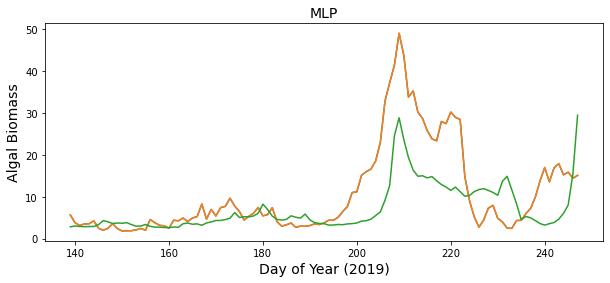

In [296]:
plt.figure(figsize=(10,4))
plt.plot(doy,actual, label='Actual')
convLSTM = predictions_convLSTM [:,6]
plt.plot(doy,actual, doy, convLSTM)
plt.title("MLP", fontsize=14)
plt.xlabel('Day of Year (2019)',fontsize=14)
plt.ylabel('Algal Biomass',fontsize=14)
plt.show()

# Multi-variate Models

## CNN multi-channel

In [320]:
def data_prep_multi(dataset, lake):
    ex=dataset[dataset.lake==lake]
    ex = ex.dropna(subset=["chl"])
    ex.zmix_hf = ex.zmix_hf.fillna(ex.zmix_daily)
    ex.temp_zmix_hf = ex.temp_zmix_hf.fillna(ex.temp_zmix_daily) 
    ex = ex.interpolate()
    #ex = ex.drop(["lake",'zmix_daily','temp_zmix_daily', 'windDir_mean', 'dosat','doy','temp_Sonde','airTemp_mean','WindGust_mean','N_mg_m2_day','pH','DOconc','Zmix_hfAve','PAR_mean','windspd_mean' ], axis=1)
    #ex["cum_p"]=ex.groupby(['year'])['p_loading'].cumsum(axis=0)
    cols = ['chl']  + ['temp_zmix_hf']+['p_cumul_over_color'] 
    ex = ex[cols]    
    return ex

In [321]:
ex_R_multi= data_prep_multi(dataset, "R")
#ex_R_multi=ex_R_multi[:-2]

In [322]:
ex_R_multi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 932 entries, 2008-05-15 to 2019-09-05
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   chl                 932 non-null    float64
 1   temp_zmix_hf        932 non-null    float64
 2   p_cumul_over_color  932 non-null    float64
dtypes: float64(3)
memory usage: 29.1 KB


In [323]:
#ex_R_multi_nor=(ex_R_multi-ex_R_multi.min())/(ex_R_multi.max()-ex_R_multi.min())*100

In [324]:
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:816], data[816:]
	# restructure into windows of weekly data
	#train = array(split(train, len(train)/7))
	#test = array(split(test, len(test)/7))
	return train, test

In [325]:
train_m, test_m= split_dataset(ex_R_multi.values)
train_m= train_m.reshape(train_m.shape[0],1, train_m.shape[1])
test_m= test_m.reshape(test_m.shape[0], 1, test_m.shape[1])

In [326]:
test_m.shape

(116, 1, 3)

In [327]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [328]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [329]:
# convert history into inputs and outputs
def to_supervised_multi(train_m, n_input, n_out=7):
	# flatten data
	data = train_m.reshape((train_m.shape[0]*train_m.shape[1], train_m.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [330]:
test_x_m, test_y_m = to_supervised_multi(test_m, 7)

In [331]:
test_x_m.shape

(103, 7, 3)

In [332]:
# make a forecast
def forecast_multi(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    # reshape into [1, n_input, n]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [333]:
# train the model
def build_model_CNN_multi(train_m, n_input):
	# prepare data
	train_x, train_y = to_supervised_multi(train_m, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 70,4
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(Conv1D(128, 2, activation='relu', input_shape=(n_timesteps,n_features), data_format='channels_first'))
	model.add(Conv1D(64, 2, activation='relu'))
	model.add(MaxPooling1D())
	model.add(Conv1D(16, 2, activation='relu'))
	model.add(MaxPooling1D())
	model.add(Flatten())
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [334]:
# evaluate a single model
def evaluate_model_CNN_multi(train_m, test_m, n_input):
	# fit model
	model = build_model_CNN_multi(train_m, n_input)
	# history is a list of weekly data
	history = [x for x in train_m]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test_m)-7):
		# predict the week
		yhat_sequence = forecast_multi(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test_m[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	test_x, test_y= to_supervised_multi(test_m, 7, 1)
	score, scores = evaluate_forecasts(test_x[:, :, 0], predictions)
	return score, scores, predictions

In [335]:
# evaluate model and get scores
n_input =7
score, scores_CNN_multi, predictions_CNN_multi = evaluate_model_CNN_multi(train_m, test_m, n_input)

In [336]:
# summarize scores
summarize_scores('Multi-channel CNN', score, scores_CNN_multi)

Multi-channel CNN: [5.543] 3.8, 4.7, 5.3, 5.7, 6.4, 6.0, 6.4


In [337]:
predictions_CNN_multi.shape

(109, 7)

In [347]:
#np.savetxt('predictions_CNN_multi_color.csv', predictions_CNN_multi, fmt='%1.6f', delimiter=',')

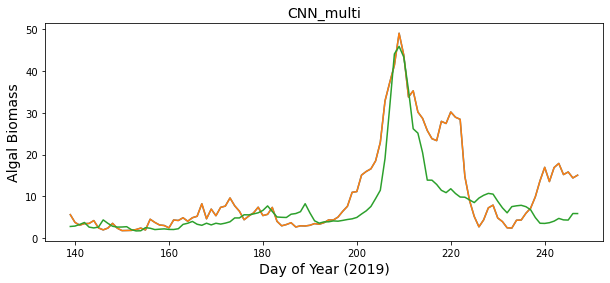

In [339]:
plt.figure(figsize=(10,4))
plt.plot(doy,actual, label='Actual')
CNN_multi = predictions_CNN_multi [:,6]
plt.plot(doy,actual, doy, CNN_multi)
plt.title("CNN_multi", fontsize=14)
plt.xlabel('Day of Year (2019)',fontsize=14)
plt.ylabel('Algal Biomass',fontsize=14)
plt.show()

## Multi-headed CCN

In [341]:
from keras.utils.vis_utils import plot_model
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.models import Model

In [342]:
# plot training history
def plot_history(history):
    # plot loss
    pyplot.subplot(2, 1, 1)
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.title('loss', y=0, loc='center')
    pyplot.legend()
    # plot rmse
    pyplot.subplot(2, 1, 2)
    pyplot.plot(history.history['rmse'], label='train')
    pyplot.plot(history.history['val_rmse'], label='test')
    pyplot.title('rmse', y=0, loc='center')
    pyplot.legend()
    pyplot.show()

In [343]:
# train the model
def build_model_multiheaded(train_m, n_input):
    # prepare data
    train_x, train_y = to_supervised_multi(train_m, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 70,4
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # create a channel for each variable
    in_layers, out_layers = list(), list()
    for _ in range(n_features):
        inputs = Input(shape=(n_timesteps,1))
        conv1 = Conv1D(32, 2, activation='relu')(inputs)
        conv2 = Conv1D(32, 2, activation='relu')(conv1)
        pool1 = MaxPooling1D()(conv2)
        flat = Flatten()(pool1)
    # store layers
        in_layers.append(inputs)
        out_layers.append(flat)
    # merge heads
    merged = concatenate(out_layers)
    # interpretation
    dense1 = Dense(100, activation='relu')(merged)
    dense2 = Dense(300, activation='relu')(dense1)
    outputs = Dense(n_outputs)(dense2)
    model = Model(inputs=in_layers, outputs=outputs)
    # compile model
    model.compile(loss='mse', optimizer='adam')
    # plot the model
    #plot_model(model, show_shapes=True, to_file='multiheaded_cnn.png')
    # fit network
    input_data = [train_x[:,:,i].reshape((train_x.shape[0],n_timesteps,1)) for i in range(n_features)]
    model.fit(input_data, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [344]:
# make a forecast
def forecast_multi_headed(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    # reshape into n input arrays
    input_x = [input_x[:,i].reshape((1,input_x.shape[0],1)) for i in range(input_x.shape[1])]
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [345]:
# evaluate a single model
def evaluate_model_multi_headed(train_m, test_m, n_input):
    # fit model
    model = build_model_multiheaded(train_m, n_input)
    # history is a list of weekly data
    history = [x for x in train_m]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test_m)-7):
        # predict the week
        yhat_sequence = forecast_multi_headed(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test_m[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    test_x, test_y= to_supervised_multi(test_m, 7, 1)
    score, scores = evaluate_forecasts(test_x[:, :, 0], predictions)
    return score, scores, predictions

In [346]:
n_input = 7
score_multi_headed, scores_multi_headed, predictions_multi_headed = evaluate_model_multi_headed(train_m, test_m, n_input)
# summarize scores
summarize_scores('multi headed_CNN', score_multi_headed, scores_multi_headed)

multi headed_CNN: [6.543] 4.9, 5.8, 6.5, 6.8, 7.0, 7.0, 7.4


In [348]:
np.savetxt('predictions_multi_headed.csv', predictions_multi_headed,fmt='%1.6f', delimiter=',')

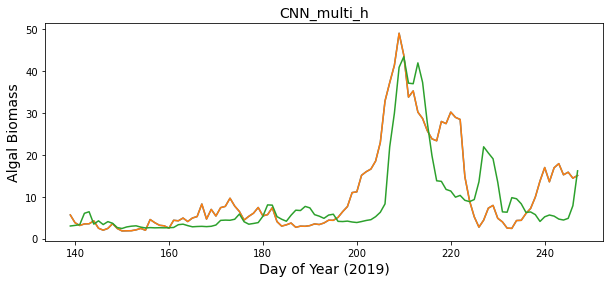

In [349]:
plt.figure(figsize=(10,4))
plt.plot(doy,actual, label='Actual')
CNN_multi_h = predictions_multi_headed [:,6]
plt.plot(doy,actual, doy, CNN_multi_h)
plt.title("CNN_multi_h", fontsize=14)
plt.xlabel('Day of Year (2019)',fontsize=14)
plt.ylabel('Algal Biomass',fontsize=14)
plt.show()

## Encoder-Decoder LSTM With Multivariate Input

In [350]:
# train the model
def build_model_LSTM_multi(train_m, n_input):
    # prepare data
    train_x, train_y = to_supervised_multi(train_m, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [351]:
# evaluate a single model
def evaluate_model_LSTM_multi(train_m, test_m, n_input):
	# fit model
	model = build_model_LSTM_multi(train_m, n_input)
	# history is a list of weekly data
	history = [x for x in train_m]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test_m)-7):
		# predict the week
		yhat_sequence = forecast_multi(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test_m[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	test_x, test_y= to_supervised_multi(test_m, 7, 1)
	score, scores = evaluate_forecasts(test_x[:, :, 0], predictions)
	return score, scores, predictions

In [352]:
# evaluate model and get scores
n_input = 7
score, scores_LSTM_multi, predictions_LSTM_multi = evaluate_model_LSTM_multi(train_m, test_m, n_input)

In [353]:
# summarize scores
summarize_scores('LSTM_multi', score, scores_LSTM_multi)


LSTM_multi: [5.412] 3.7, 4.5, 5.1, 5.5, 5.9, 6.2, 6.5


In [354]:
predictions_LSTM_multi= predictions_LSTM_multi.reshape(predictions_LSTM_multi.shape[0], predictions_LSTM_multi.shape[1])

In [355]:
np.savetxt('predictions_LSTM_multi.csv', predictions_LSTM_multi, fmt='%1.6f', delimiter=',')

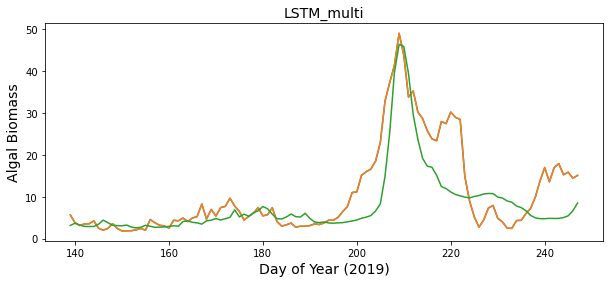

In [356]:
plt.figure(figsize=(10,4))
plt.plot(doy,actual, label='Actual')
LSTM_multi = predictions_LSTM_multi [:,6]
plt.plot(doy,actual, doy, LSTM_multi)
plt.title("LSTM_multi", fontsize=14)
plt.xlabel('Day of Year (2019)',fontsize=14)
plt.ylabel('Algal Biomass',fontsize=14)
plt.show()

# Summarize results

### Plot 1- Comparing the performance (RMSE) of Univariate Models

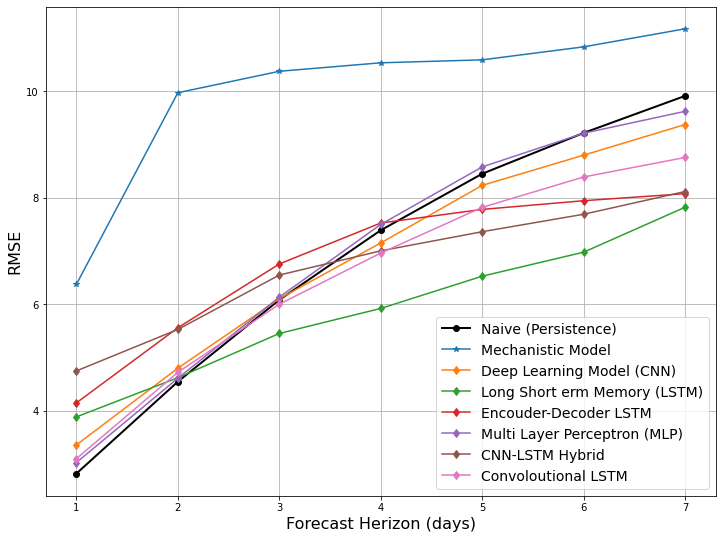

In [358]:
days = ['1', '2', '3', '4', '5', '6', '7']
mech = [6.371254058, 9.964882012,10.3674918,10.52675684,10.58225691,10.82599927,11.16455892]
# plot scores
pyplot.figure(figsize=(12,9))
pyplot.title("7-day forecast, lake Peter, 2019", fontsize=14)
pyplot.plot(days, scores_Naive,marker='o', label="Naive (Persistence)", color='Black', linewidth=2)
pyplot.plot(days, mech,marker='*', label="Mechanistic Model")
pyplot.plot(days, scores_CNN,marker='d', label="Convolutional Neurral Network (CNN)")
pyplot.plot(days, scores_LSTM,marker='d', label="Long Short erm Memory (LSTM)")
pyplot.plot(days, scores_LSTM_EnDe,marker='d', label="Encouder-Decoder LSTM")
pyplot.plot(days, scores_MLP,marker='d', label="Multi Layer Perceptron (MLP)")
pyplot.plot(days, scores_hybrid,marker='d', label="CNN-LSTM Hybrid")
pyplot.plot(days, scores_convLSTM,marker='d', label="Convoloutional LSTM")


# show plot
pyplot.legend(fontsize=14, loc=4)
pyplot.grid()
pyplot.xlabel("Forecast Herizon (days)",fontsize=16)
pyplot.ylabel("RMSE",fontsize=16)
pyplot.savefig('/Volumes/GoogleDrive/My Drive/UVa/Spring2019/Presidential Fellowship/comparison paper/Figures/performance.jpeg')
pyplot.show()

In [ ]:
scores_CNN_multi, scores_multi_headed, scores_LSTM_multi

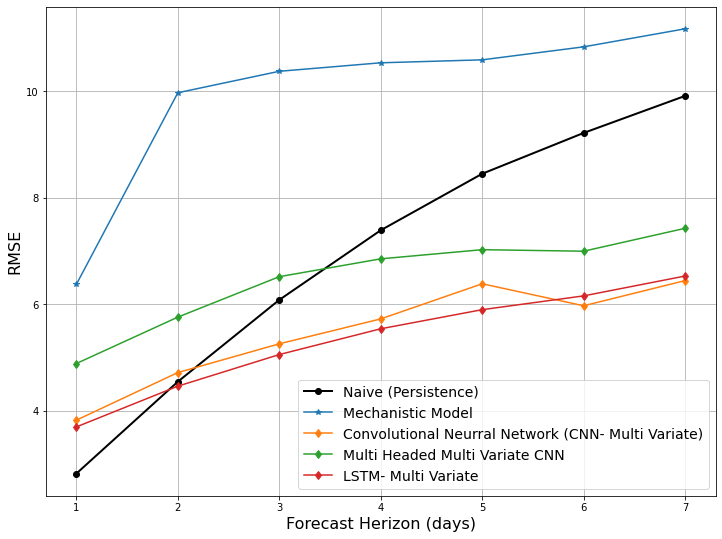

In [359]:
days = ['1', '2', '3', '4', '5', '6', '7']
mech = [6.371254058, 9.964882012,10.3674918,10.52675684,10.58225691,10.82599927,11.16455892]
# plot scores
pyplot.figure(figsize=(12,9))
pyplot.plot(days, scores_Naive,marker='o', label="Naive (Persistence)", color='Black', linewidth=2)
pyplot.plot(days, mech,marker='*', label="Mechanistic Model")
pyplot.plot(days, scores_CNN_multi,marker='d', label="Convolutional Neurral Network (CNN- Multi Variate)")
pyplot.plot(days, scores_multi_headed,marker='d', label="Multi Headed Multi Variate CNN")
pyplot.plot(days, scores_LSTM_multi,marker='d', label="LSTM- Multi Variate")

# show plot
pyplot.legend(fontsize=14, loc=4)
pyplot.grid()
pyplot.xlabel("Forecast Herizon (days)",fontsize=16)
pyplot.ylabel("RMSE",fontsize=16)
pyplot.savefig('/Volumes/GoogleDrive/My Drive/UVa/Spring2019/Presidential Fellowship/comparison paper/Figures/performance.jpeg')
pyplot.show()